In [ ]:
# Install czmodel and dependencies
! pip install --upgrade pip
! pip install "czmodel>=3.0,<4.0"

In [1]:
# This can be used to switch on/off warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Simple TF2 + Keras model for segmentation (to detect cell nuclei)
This notebook the entire workflow of training an ANN with [TensorFlow 2](https://www.tensorflow.org/) using the keras API and exporting the trained model to the [CZANN format](https://pypi.org/project/czmodel/) to be ready for use within the [Intellesis](https://www.zeiss.de/mikroskopie/produkte/mikroskopsoftware/zen-intellesis-image-segmentation-by-deep-learning.html) infrastructure.

* The trained model is rather simple (for demo purposes) and trained on a small test dataset.
* **Therefore, this notebook is meant to be understood as a guide for exporting trained models.**
* **The notebook does not provide instructions how train a model correctly.**

## Imports

In [2]:
# Required imports to train a simple TF2 + Keras model for segmentation and package it as CZANN.
# The CZANN can then be imported in ZEN and used for segmentation and image analysis workflows.

# General imports
import os
import tensorflow as tf
import numpy as np

# Function provided by the PyPI package called czmodel (by ZEISS)
from czmodel.model_metadata import ModelMetadata, ModelSpec, ModelType
from czmodel.legacy_model_metadata import ModelMetadata as LegacyModelMetadata, ModelSpec as LegacyModelSpec
from czmodel import DefaultConverter, LegacyConverter
from czmodel.util.transforms import Shift, Scale

In [3]:
# Optional: suppress TF warnings
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
print(tf.version.GIT_VERSION, tf.__version__)

v2.8.0-rc1-32-g3f878cff5b6 2.8.0


## Training Pipeline
This section describes a simple training procedure that creates a trained Keras model.

* Therefore, it only represents the custom training procedure
* Such procedure will vary from case to case and will contain more sophisticated ways to generate an optimized Keras model

### Define parameters for data loading

In [4]:
# Folder containing the input images
IMAGES_FOLDER = 'nucleus_data/images/'

# Folder containing the ground truth segmentation masks
# Mask images have one channel with a unique value of each class (0=background and 1=nucleus)
MASKS_FOLDER = 'nucleus_data/labels/'

# Path to the data on GitHub
GITHUB_TRAINING_DATA_PATH = 'https://raw.githubusercontent.com/zeiss-microscopy/OAD/master/Machine_Learning/notebooks/czmodel/nucleus_data.zip'
GITHUB_MODEL_CONVERSION_SPEC_PATH = 'https://raw.githubusercontent.com/zeiss-microscopy/OAD/master/Machine_Learning/notebooks/czmodel/model_conversion_spec.json'

# Define the number of input color channels
# This means that the inputs are grayscale with one channel only
CHANNELS = 1 

# The size of image crops to train the model with
CROP_SIZE = 512

### Download data if it's not available on disk
If this notebook is run e.g. as a colab notebook, it does not have access to the data folder on gitub via disk access. 
In that case we need to download the data from github first.

In [5]:
import requests

# Download training data
if not (os.path.isdir(IMAGES_FOLDER) and os.path.isdir(MASKS_FOLDER)):
    compressed_data = './nucleus_data.zip'
    if not os.path.isfile(compressed_data):
        import io
        response = requests.get(GITHUB_TRAINING_DATA_PATH, stream=True)
        compressed_data = io.BytesIO(response.content)
        
    import zipfile
    with zipfile.ZipFile(compressed_data, 'r') as zip_accessor:
        zip_accessor.extractall('./')
        
# Download model conversion spec
if not os.path.isfile('model_conversion_spec.json'):
    response = requests.get(GITHUB_MODEL_CONVERSION_SPEC_PATH, stream=True)
    with open('model_conversion_spec.json', 'wb') as handle:
        handle.write(response.content)

### Read images
This part contains the logic to read pairs of images and label masks for training

In [6]:
def order_unique_values(mask):
    for i, unique_value in enumerate(np.unique(mask)):
        mask[mask == unique_value] = i
    return mask

In [7]:
# Determine the paths of the input samples
sample_images = sorted([os.path.join(IMAGES_FOLDER, f) for f in os.listdir(IMAGES_FOLDER) 
                        if os.path.isfile(os.path.join(IMAGES_FOLDER, f))])

# Determine the paths of the corresponding masks
sample_masks = sorted([os.path.join(MASKS_FOLDER, f) for f in os.listdir(MASKS_FOLDER) 
                       if os.path.isfile(os.path.join(MASKS_FOLDER, f))])

# Load images as numpy arrays and scale to interval [0..1]
images_loaded = np.asarray(
    [
        tf.image.decode_image(
            tf.io.read_file(sample_path), channels=CHANNELS, dtype=tf.uint16
        ).numpy().astype(np.float32) / (2**16 - 1)
        for sample_path in sample_images
    ]
)

In [8]:
# Normalize images
images_mean = images_loaded.mean(axis=(0,1,2))
images_std = images_loaded.std(axis=(0,1,2))
images_loaded = (images_loaded - images_mean) / images_std

In [9]:
# Load labels as numpy arrays amd convert to one-hot representation
masks_loaded = np.asarray([
    tf.one_hot(
        tf.convert_to_tensor(
            order_unique_values(tf.image.decode_image(tf.io.read_file(sample_path), channels=1)[...,0].numpy())
        ), depth=2
    ).numpy()
    for sample_path in sample_masks
])

Remark: For details see [tf.one_hot](https://www.tensorflow.org/api_docs/python/tf/one_hot)

`tf.one_hot creates X channels from X labels: 1 => [0.0, 1.0], 0 => [1.0, 0.0]`

### Define a TensorFlow dataset to pre-process the images
Since the dataset contains very large images we need to train on smaller crops in order to not exhaust the GPU memory

In [10]:
# Define a simple random crop transformation to train on smaller crops
def random_crop(image, mask, height, width):
    stacked = tf.concat([image, mask], axis=-1)
    stacked_cropped = tf.image.random_crop(
        stacked,
        size=tf.stack([height, width, tf.shape(image)[-1] + tf.shape(mask)[-1]], axis=0)
    )
    image_cropped = stacked_cropped[..., :tf.shape(image)[-1]]
    mask_cropped = stacked_cropped[..., tf.shape(image)[-1]:]
    return image_cropped, mask_cropped

# Define a TensorFlow dataset applying the random crop and batching the training data.
dataset = tf.data.Dataset.from_tensor_slices(
    ((images_loaded, masks_loaded))
).map(
    lambda x, y: random_crop(x, y, CROP_SIZE, CROP_SIZE)
).shuffle(10).batch(8)

### Define a simple model
This part defines a simple Keras model with two convolutional layers and softmax activation at the output node. It is also possible to add pre-processing layers to the model here.

In [11]:
# Define simple Keras model with two convolutional layers and softmax activation at the output node
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Conv2D(16, 3, padding='same'), 
        tf.keras.layers.Conv2D(2, 1, activation='softmax', padding='same')
    ]
)

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

### Fit the model to the loaded data
This part fits the model to the loaded data. In this test example we do not care about an actual evaluation of the model using validation and test datasets.

In [12]:
# define number of training epochs
NUM_EPOCHS = 25

# fit the model to the data
model.fit(dataset, epochs=NUM_EPOCHS)

Epoch 1/25
2/2 [==============================] - 4s 144ms/step - loss: 0.7997 - categorical_accuracy: 0.0246
Epoch 2/25
2/2 [==============================] - 0s 19ms/step - loss: 0.7415 - categorical_accuracy: 0.0334
Epoch 3/25
2/2 [==============================] - 0s 25ms/step - loss: 0.6939 - categorical_accuracy: 0.7430
Epoch 4/25
2/2 [==============================] - 0s 28ms/step - loss: 0.6470 - categorical_accuracy: 0.9462
Epoch 5/25
2/2 [==============================] - 0s 29ms/step - loss: 0.6046 - categorical_accuracy: 0.9668
Epoch 6/25
2/2 [==============================] - 0s 35ms/step - loss: 0.5688 - categorical_accuracy: 0.9734
Epoch 7/25
2/2 [==============================] - 0s 37ms/step - loss: 0.5322 - categorical_accuracy: 0.9711
Epoch 8/25
2/2 [==============================] - 1s 28ms/step - loss: 0.5014 - categorical_accuracy: 0.9772
Epoch 9/25
2/2 [==============================] - 0s 29ms/step - loss: 0.4764 - categorical_accuracy: 0.9712
Epoch 10/25
2/2 [=

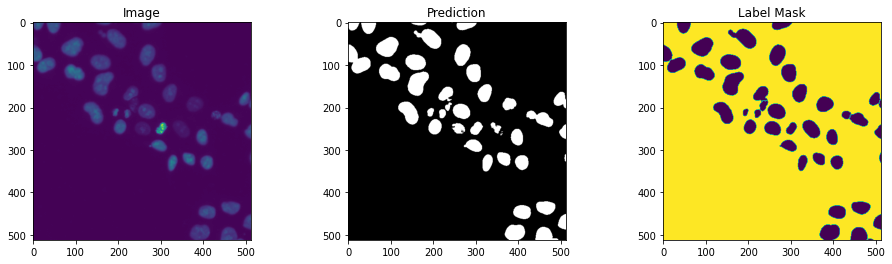

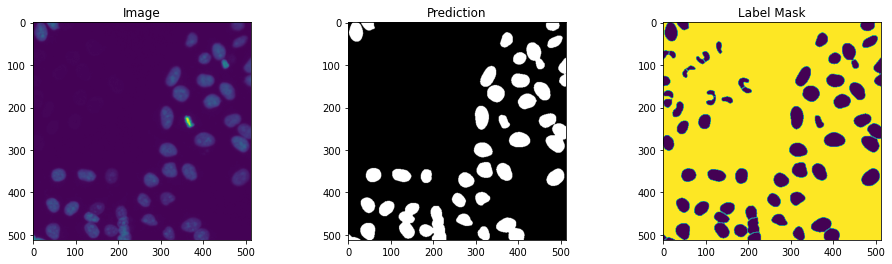

In [13]:
import matplotlib.pyplot as plt

# get an image and a mask from the dataset
for img, mask in dataset:

    #run the prediction and get the masks using argmax
    pred = model.predict(img)[0]
    pred = np.argmax(pred, axis=-1)

    # show some results
    img_scaled = img.numpy()[0] / img.numpy().max()
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_figwidth(16)

    # show images and set titles
    ax1.imshow(img_scaled[...,0])
    ax2.imshow(pred, cmap="gray", vmin=0, vmax=1)
    ax3.imshow(mask[0,...,0])

    ax1.set_title('Image')
    ax2.set_title('Prediction')
    ax3.set_title('Label Mask')

## Create a CZANN/CZSEG from the trained Keras model
In this section we export the trained model to the CZANN format using the czmodel library and some additional meta data all possible parameter choices are described in the [ANN model specification](https://pypi.org/project/czmodel/).

### Define Meta Data
We first define the meta data needed to run the model within the Intellesis infrastructure. The `czmodel` package offers a named tuple `ModelMetadata` that allows to either parse as JSON file as described in the [specification document](https://pypi.org/project/czmodel/) or to directly specify the parameters as shown below.

### Create a Model Specification Object
The export functions provided by the `czmodel` package expect a `ModelSpec` tuple that features the Keras model to be exported, the corresponding model meda data and optionally a license file for the model.

Therefore, we wrap our model and the `model_metadata` instance into a `ModelSpec` object.

In [14]:
# Define dimensions - ZEN Intellesis requires fully defined spatial dimensions in the meta data of the CZANN model.
# The ZEN TilingClient uses the input shape in the meta data to infer the tile size to pass an image to the inferencer.
# Important: The tile size has to be chosen s.t. inference is possible with the minimum hardware requirements of Intellesis
# Optional: Define target spatial dimensions of the model for inference.
input_size = 1024

# Define the model metadata
model_metadata = ModelMetadata(
    input_shape=[input_size, input_size, 1],
    output_shape=[input_size, input_size, 2],
    model_type=ModelType.SINGLE_CLASS_SEMANTIC_SEGMENTATION,
    classes=["Background", "Nucleus"],
    model_name="Simple_Nuclei_SegmentationModel",
    min_overlap=[8, 8],
)
model_spec = ModelSpec(
    model=model,
    model_metadata=model_metadata,
    license_file=None
)

model_metadata_legacy = LegacyModelMetadata(
    name="Simple_Nuclei_SegmentationModel_Legacy",
    classes=["Background", "Nucleus"],
    pixel_types="Gray16",
    color_handling="SplitRgb",
    border_size=8,
)
model_spec_legacy = LegacyModelSpec(
    model=model,
    model_metadata=model_metadata_legacy,
    license_file=None
)

# Define pre-processing
preprocessing = [
    Shift(-images_mean),
    Scale(1.0 / images_std)
]
preprocessing_legacy = [ # Mean and sandard deviation must be scaled according to the bit depth of the input images
    Shift(-images_mean * (2**16 - 1)),
    Scale((2**16 - 1) / images_std)
]

### Perform model export into *.czann / *.czseg file format

The converters from the `czmodel` library offers two functions to perform the actual export. 

* `convert_from_json_spec` allows to provide a JSON file containing all the information of a ModelSpec object and converts a model in SavedModel format on disk to a `.czann` / `.czseg` file that can be loaded with ZEN.
* `convert_from_model_spec` expects a `ModelSpec` object, an output path and name and optionally target spatial dimensions for the expected input of the exported model. From this information it creates a `.czann` / `.czseg` file containing the specified model.

Currently, `czmodel` offers two converters:
* DefaultConverter: Converts a model to a *.czann file.
* LegacyConverter: Converts a model to a *.czseg file (legacy format).

In [15]:
DefaultConverter().convert_from_model_spec(
    model_spec=model_spec, 
    output_path='./', 
    output_name='simple_nuclei_segmodel',
    spatial_dims=(input_size, input_size),
    preprocessing=preprocessing
)

# In the example above there will be a ""./czmodel_output/simple_nuclei_segmodel.czann" file saved on disk.

'--tag' not specified for saved_model. Using --tag serve
'--signature_def' not specified, using first signature: serving_default


In [16]:
LegacyConverter().convert_from_model_spec(
    model_spec=model_spec_legacy, 
    output_path='./', 
    output_name='simple_nuclei_segmodel_legacy',
    spatial_dims=(input_size, input_size),
    preprocessing=preprocessing_legacy
)

'--tag' not specified for saved_model. Using --tag serve
'--signature_def' not specified, using first signature: serving_default


## Remarks
The generated .czann and .czseg files can be directly loaded into ZEN Intellesis to perform segmentation tasks with the trained model.
If there is already a trained model in SavedModel format present on disk, it can also be converted by providing the path to the saved model directory instead of a Keras `Model` object. The `czmodel` library will implicitly load the model from the provided path.

The `czmodel` library also provides a `convert_from_json_spec` function that accepts a JSON file with the above mentioned meta data behind the key `ModelMetadata` which will implicitly be deserialized into a `ModelMetadata` object, the model path and optionally a license file:
```json
{
    "ModelMetadata": {
        "Type": "SingleClassSemanticSegmentation",
        "Classes": ["Background", "Nucleus"],
        "InputShape": [1024, 1024, 1],
        "OutputShape": [1024, 1024, 2],
        "ModelName": "Nuclei Segmentation Model From JSON",
        "MinOverlap": [8, 8]
    },
    "ModelPath": "./saved_tf2_model_output/",
    "LicenseFile": null
}
```

This information can be copied to a file e.g. in the current working directory `./model_conversion_spec.json` that also contains the trained model in SavedModel format e.g. generated by the following line:

In [17]:
# save the trained TF2.SavedModel as a folder structure
# The folder + the JSON file can be also used to import the model in ZEN

model.save('./saved_tf2_model_output/')

In [18]:
# This is an additional way to create a CZANN from a saved TF2 model on disk + JSON file.
# The currently recommended way to to create the CZANN directly by using czmodel.convert_from_model_spec
# the path to the TF2.SavedModel folder is defined in the JSON shown above

DefaultConverter().convert_from_json_spec(
    model_spec_path='model_conversion_spec.json',
    output_path='./',
    output_name = 'simple_nuclei_segmodel_from_json',
    spatial_dims=(input_size, input_size),
    preprocessing=preprocessing
)

'--tag' not specified for saved_model. Using --tag serve
'--signature_def' not specified, using first signature: serving_default


Use the commands below from a terminal to present the notebook as a slideshow.

`
jupyter nbconvert SingleClassSemanticSegmentation_3_0_0.ipynb --to slides --post serve 
    --SlidesExporter.reveal_theme=serif 
    --SlidesExporter.reveal_scroll=True 
    --SlidesExporter.reveal_transition=none
`